In [27]:
from utils.util import set_env, auto_log_and_state
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from modules.rss import RSSGetter
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from ml_collections import ConfigDict
from datetime import datetime

In [28]:
# 1단계 : 최신 뉴스 검색 필요한건지 파악
# 2단계 -1) 뉴스 검색했다면 바로 답변
# 2단계 -2) 뉴스 검색 아니라면 아는 내용인지 판단
# 3단계 -1) 아는 내용이면 바로 답변
# 3단계 -2) 모르는 내용이면 검색후 답변

# 해야할것
# 1. 아는 내용인지 모르는내용인지 판단하는 로직 추가
# 2. 뉴스 전처리 코드 추가
# 3. 뉴스 검색 이후 답변 추가
# 4. 답변하기 추가

In [29]:
rss = RSSGetter()
set_env()
llm = ChatOpenAI(model="gpt-4o")

In [30]:
system_prompt = "You are a helpful assistant"

In [31]:
class DecideSearchOutput(BaseModel):
    content: str = Field(description="YES or NO")

class DecideExistingInfoOutput(BaseModel):
    content: str = Field(description="YES or NO")
    
class SearchInfo(BaseModel):
    ko_keyword: str = Field(description="한국어 검색어")
    en_keyword: str = Field(description="영어 검색어")
    start_date: str = Field(description="검색 시작 날짜")
    end_date: str = Field(description="검색 종료 날짜")

In [40]:
prompt_config = ConfigDict()
prompt_config.decide_search = """다음 사용자 요청문이 뉴스 검색을 요청하는 내용인지 판단하세요.

사용자 요청문 : {query}

반드시 답변은 아래 출력 양식을 참고하세요.

{format_instructions}
"""

prompt_config.decide_existing_info = """다음 사용자 요청문이 당신이 충분히 답변할 수 있는 내용인지 판단하세요.

사용자 요청문 : {query}

반드시 답변은 아래 출력 양식을 참고하세요.

{format_instructions}
"""

prompt_config.generate_search_info = f"""다음 사용자 요청문에 대한 검색 정보를 생성하세요.

사용자 요청문 : {{query}}

반드시 답변은 아래 출력 양식을 참고하세요. 사용자 요청문에 기간 정보가 없다면, 검색 시작 날짜와 종료 날짜 사이는 최소 2개월 이상으로 설정합니다. 오늘 날짜 : {datetime.now().strftime("%Y-%m-%d")}

한국어 검색어 :
영어 검색어 :
검색 시작 날짜 : YYYY-MM-DD
검색 종료 날짜 : YYYY-MM-DD"""

In [44]:
class State(MessagesState):
    messages: str

def decide_search(state:State):
    state["format_instructions"] = PydanticOutputParser(pydantic_object=DecideSearchOutput).get_format_instructions()
    state['query'] = state['messages'][0].content
    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt_config.decide_search.format_map(state))
    ]
    structured_llm = llm.with_structured_output(DecideSearchOutput)
    result = structured_llm.invoke(prompt).content.strip()
    if result == "YES":
        return "Node__search"
    else:
        return "Node__answer"

def Node__search(state:State):
    state['query'] = state['messages'][0].content
    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt_config.generate_search_info.format_map(state))
    ]
    structured_llm = llm.with_structured_output(SearchInfo)
    search_info = structured_llm.invoke(prompt)
    print("search_info.en_keyword : ", search_info.en_keyword)
    print("search_info.ko_keyword : ", search_info.ko_keyword)
    print("search_info.start_date : ", search_info.start_date)
    print("search_info.end_date : ", search_info.end_date)
    en_news, ko_news = rss(en_keyword=search_info.en_keyword, 
                           ko_keyword=search_info.ko_keyword, 
                           start_date=search_info.start_date, 
                           end_date=search_info.end_date)
    return state

def Node__answer(state:State):
    prompt = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["messages"])
    ]
    return_state = {"messages": [llm.invoke(prompt)]}
    return return_state

   
# Build Graph
builder = StateGraph(State)

# Set Node
builder.add_node("Node__answer", Node__answer)
builder.add_node("Node__search", Node__search)

# Set Edge
builder.add_conditional_edges(START, decide_search)
builder.add_edge("Node__search", END)
builder.add_edge("Node__answer", END)

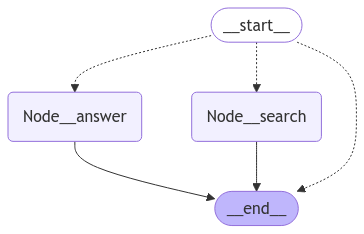

In [45]:
# Compile Graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
graph.invoke({"messages":"최신 경제 뉴스 2개 알려줘"})

search_info.en_keyword :  latest economic news
search_info.ko_keyword :  최신 경제 뉴스
search_info.start_date :  2024-11-01
search_info.end_date :  2025-01-06
### 🚩 영어로 작성된 뉴스 자료들을 검색합니다.


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


4개의 뉴스 자료를 수집하였습니다.
### 🚩 한국어로 작성된 뉴스 자료들을 검색합니다.


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  6.15it/s]

2개의 뉴스 자료를 수집하였습니다.


{'messages': [HumanMessage(content='최신 경제 뉴스 2개 알려줘', additional_kwargs={}, response_metadata={}, id='706bc757-d353-4609-af1c-31a61d2b97a5')]}

In [12]:
import requests
from bs4 import BeautifulSoup
def google_search_scrape(query, 
                         num_results=3):
    """
        Des:
            Google 검색 결과를 스크래핑하는 함수
        Args:
            query (str): 검색할 키워드
            num_results (int): 검색 결과 수
        Returns:
            list: 검색 결과를 담은 리스트
    """
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
    query = query.replace(" ", "+")
    url = f"https://www.google.com/search?q={query}&num={num_results}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    results = []
    for g in soup.find_all("div", class_="tF2Cxc"):
        title = g.find("h3").text.upper()
        link = g.find("a")["href"]
        results.append({"title": title, "link": link})
    return results